# Exploratory Data Analysis and Business Insights

In [54]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv

load_dotenv()
sns.set_theme(rc = {'figure.figsize':(15,8)}, style='whitegrid', palette='Greys_r')

## Creating connection

In [2]:
db_url = os.getenv('DB_URL')
engine = create_engine(db_url)

## EDA

### Fact Orders

In [3]:
df_fo = pd.read_sql('SELECT * FROM fact_orders', con=engine)

In [125]:
display(df_fo.sample(10))

,order_id,customer_id,order_status,purchase_ts,delivered_customer_ts,days_to_deliver,total_price,total_freight_price,unique_customer_id,customer_city,customer_state,total_payment_value,payment_methods,total_reviews,avg_score
48894,67519e1fe10bb3e4a5b416a24f846f8e,f8291e8b8489bfd516ec56628058a810,delivered,2017-06-07,2017-07-03,26.0,15.9,11.85,87da014df37ac571be8a9f6a9129b02c,sao jose do rio preto,SP,27.75,[credit_card],1.0,1.0
71189,5ce6c2a88e2b68d791065155debf44f8,dc238912e54163b9714b4a07ef017a9b,delivered,2018-03-31,2018-04-11,11.0,149.9,18.93,5dc396375991e0b11446f0855bb4b53b,piraju,SP,168.83,[credit_card],1.0,5.0
49128,99e5f0c685ca94e5a1c7134b1898bb1a,fabf206541756ff848d31278960701ac,delivered,2018-08-08,2018-08-13,5.0,29.0,7.46,6c6ff848f6f705ca1235ac80c414f709,sao paulo,SP,38.94,[credit_card],1.0,5.0
76196,0aba4750be63d17b0b841afb6a84a629,1052ae24b3c5acdf4c7f5d4165a11dbf,delivered,2017-11-08,2017-11-14,6.0,199.0,13.52,885f85d419d323a54c3f4645893fe568,timoteo,MG,212.52,[credit_card],1.0,5.0
25860,380bf78bcf690a6955b8f1de575e26ba,0a8189ab957e37ec9490424e8ecf9050,delivered,2017-03-11,2017-03-22,11.0,239.0,15.84,1bb560cf89ba509f0a4feea96c49c9b3,cantagalo,RJ,254.84,[boleto],1.0,5.0
58116,3aae5f4d2c104f1d6f7620143be23d7f,5670e8edb5152237d23bfc18f0c96e72,delivered,2018-04-09,2018-04-12,3.0,94.0,15.42,9e5c0aa8fea0b95101919e8381480c75,sete lagoas,MG,109.42,[credit_card],1.0,5.0
77640,a46f7d82e8993040636ec55fdcc99272,1f12b97b42f31c818d0db045e5cbad20,delivered,2018-03-18,2018-03-22,4.0,89.9,14.71,98f65b8fa9379231a7c62bdd011ee434,muriae,MG,104.61,[credit_card],1.0,4.0
67612,77e30dea9bbb161e9d91918418f4aafa,b71cb835be11fec9d0e0903e4d9acefe,delivered,2017-08-03,2017-08-08,5.0,65.0,12.70,900886a4542c9007300e081b6ce4eca6,canoinhas,SC,77.70,[credit_card],1.0,5.0
6785,a1f12bceaff1b0d9d2a457fca14d1fa1,460d69a7f123395d881d1122d36e0f87,delivered,2017-11-02,2017-11-10,8.0,39.0,12.69,487b4ea515b16a8a3bae87a0c487b438,barueri,SP,51.69,[credit_card],1.0,4.0
82432,70aae84b2facb982a1867a6793603919,5109b8e49bfa15c2481451462d214558,delivered,2018-04-18,2018-05-02,14.0,179.0,19.13,da010535ae63c9fd86077efeadcd5e88,brasilia,DF,198.13,[credit_card],1.0,3.0


### Fact Order Items

In [98]:
df_foi = pd.read_sql('SELECT * FROM fact_order_items', con=engine)

In [99]:
display(df_foi.sample(10))

,order_id,order_item_number,product_id,price,freight_price,seller_id,category_name,seller_city,seller_state,order_status,customer_id,purchase_ts,delivered_customer_ts,unique_customer_id,customer_city,customer_state
75911,f41ef35b2b93249c5239c5df242e8b28,1,5d6bea33648f018dbb563f3a2fab09f3,150.00,13.95,1025f0e2d44d7041d6cf58b6550e0bfa,furniture_decor,sao paulo,SP,delivered,ac312444c1b3a645bf132fadfa1bede4,2018-05-09 16:59:45,2018-05-15 19:05:55,11a70f262b8ebca18b88fcb5a5f6882b,rio claro,SP
99819,ccfa13cff25aa5ad005e434ac68acaaa,1,154e7e31ebfa092203795c972e5804a6,23.99,14.10,cc419e0650a3c5ba77189a1882b7556a,health_beauty,santo andre,SP,shipped,e27c0fc7980d78b52c7a97cb7c8e10f0,2017-10-21 15:54:50,NaT,6e6fdec52c6dbf58721bf7a4eaf5b679,belo horizonte,MG
40,7ad292313f72d59700c72169ba543021,1,329851bd191cfd30470ffd5aa5457c23,37.90,13.37,dbc22125167c298ef99da25668e1011f,luggage_accessories,borda da mata,MG,delivered,0018f7fde63ca77254dbc47f4ea358b2,2017-09-26 14:01:47,2017-10-03 21:58:55,392c8818b71b14227a7c701e7d54a3a1,pirassununga,SP
95898,6e6bacc052a79d14a6e7d015188bef50,1,3344f3ccc35b04b81d8cc2aefabcbcdd,499.99,22.99,46dc3b2cc0980fb8ec44634e21d2718e,baby,rio de janeiro,RJ,delivered,d962db498655c9a4b77db1b993f157d4,2018-02-27 17:55:16,2018-04-16 17:24:24,cbe90a29307025b1aa98d02ad2271c0a,brasilia,DF
5204,b16d1a2fcbe45897eb78950e1b542c63,1,30e2b9deadd5211496426065065c71a7,59.00,12.85,8a432f4e5b471f8da497d7dc517666e2,baby,presidente prudente,SP,delivered,0bdcc03d8ea14230b19bdb4efdc87963,2018-04-05 11:05:44,2018-04-11 12:54:48,f366cf5176bb3cd330e74d8e14b8e13c,boituva,SP
108409,b362e77722405d304dc6fb5947ea3bea,1,fb783e3e545937820b57fe539b2c5a6c,99.90,17.95,da8622b14eb17ae2831f4ac5b9dab84a,bed_bath_table,piracicaba,SP,delivered,f62c129511fd69648c45b74571444807,2017-09-05 21:43:55,2017-09-26 20:08:14,7e9a6816b16e741309a79f3b55df4754,tres lagoas,MS
23318,c7a41978e3a504f1f6281e82e05c07f7,1,aadd486ebe3c20e6e07fa2a40d557a00,75.99,19.12,7a67c85e85bb2ce8582c35f2203ad736,cool_stuff,sao paulo,SP,delivered,34eaceb9c054e70d3902b70fa7052c77,2017-03-03 11:18:53,2017-03-16 15:52:19,ccb07bccc29a9ab276f256444045bc47,coxim,MS
16662,2d62a673525d6861e6f5f7ea6969c96c,1,c48aa9017e58836324227e1d2209e9ca,65.90,12.90,d12c926d74ceff0a90a21184466ce161,furniture_decor,sao paulo,SP,delivered,25965361605f7bee4609f204dced6ccc,2018-03-22 23:59:55,2018-03-29 19:58:24,6f65f19c2dcfcab8b76b2fafb5b840e1,aracatuba,SP
47883,d656f5c86159b4cc6d5a11af77d7efde,1,0cf13ac73dbcf6586ba63b89dd1f780a,47.00,16.11,b14db04aa7881970e83ffa9426897925,furniture_decor,sorocaba,SP,delivered,6d08a140cd85228349360a6b914ea47f,2017-06-13 11:08:44,2017-06-27 18:32:53,db9b63e149f67cf632ad60d9f7718e0a,itatiaia,RJ
112006,019b8e16e30c8b9ad9bf87e039a27765,1,5d0386961a44323a9772e63672317131,99.99,13.72,5b67882648febfb6e1225e6ad7164f6b,sports_leisure,umuarama,PR,delivered,fe9cb076acaffbee858187352e2f7266,2017-07-25 20:10:18,2017-08-04 17:42:22,15cdca72d93fc92eab25e4484f9fcb88,sao paulo,SP


## Business Insights

### 1. # and % of Orders per status

In [53]:
df_1 = pd.read_sql("""
    SELECT DISTINCT order_status, 
      COUNT(DISTINCT order_id) AS total_orders
    FROM fact_orders
    GROUP BY 1 
    ORDER BY 2 DESC
""", con=engine)

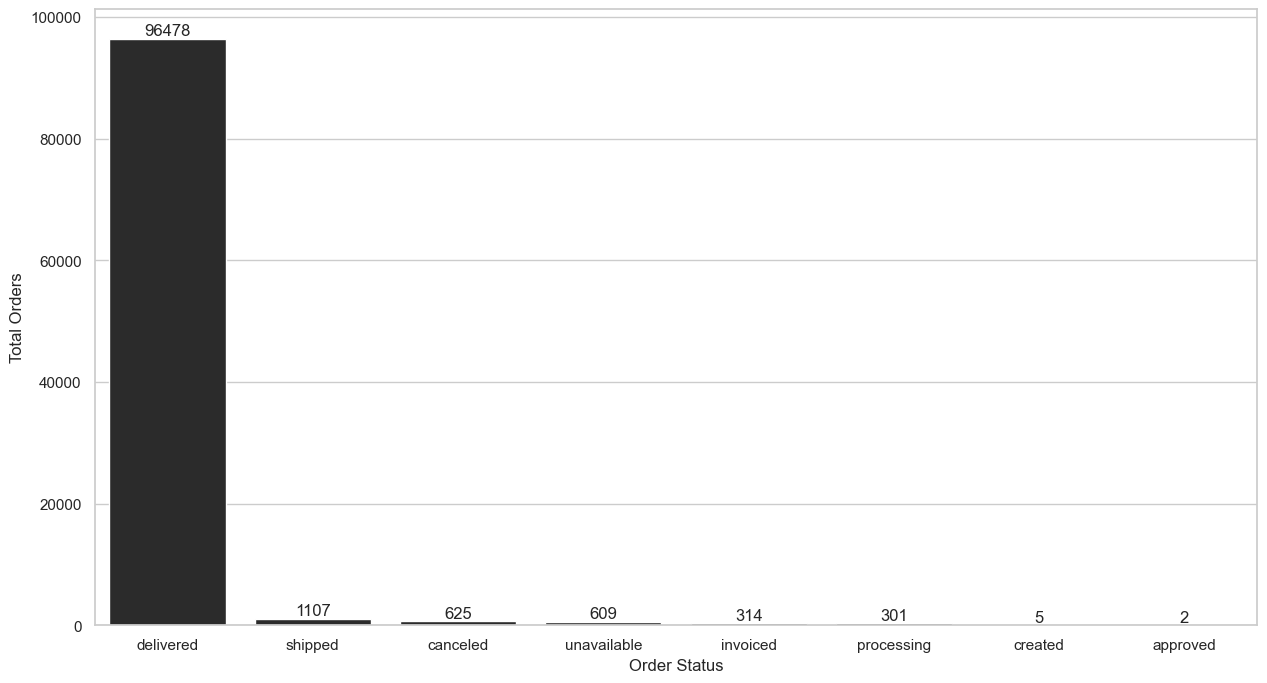

In [54]:
ax = sns.barplot(data=df_1, x='order_status', y='total_orders')
ax.set_xlabel('Order Status')
ax.set_ylabel('Total Orders')
ax.bar_label(ax.containers[0], fontsize=12);

### 2. # of Orders Over Time

In [60]:
df_2 = pd.read_sql("""
    SELECT DISTINCT DATE(DATE_TRUNC('month', purchase_ts)) as dt_ref, 
        COUNT(DISTINCT order_id) as tt_orders
    FROM fact_orders
    GROUP BY 1
    ORDER BY 1 ASC
""", con=engine)

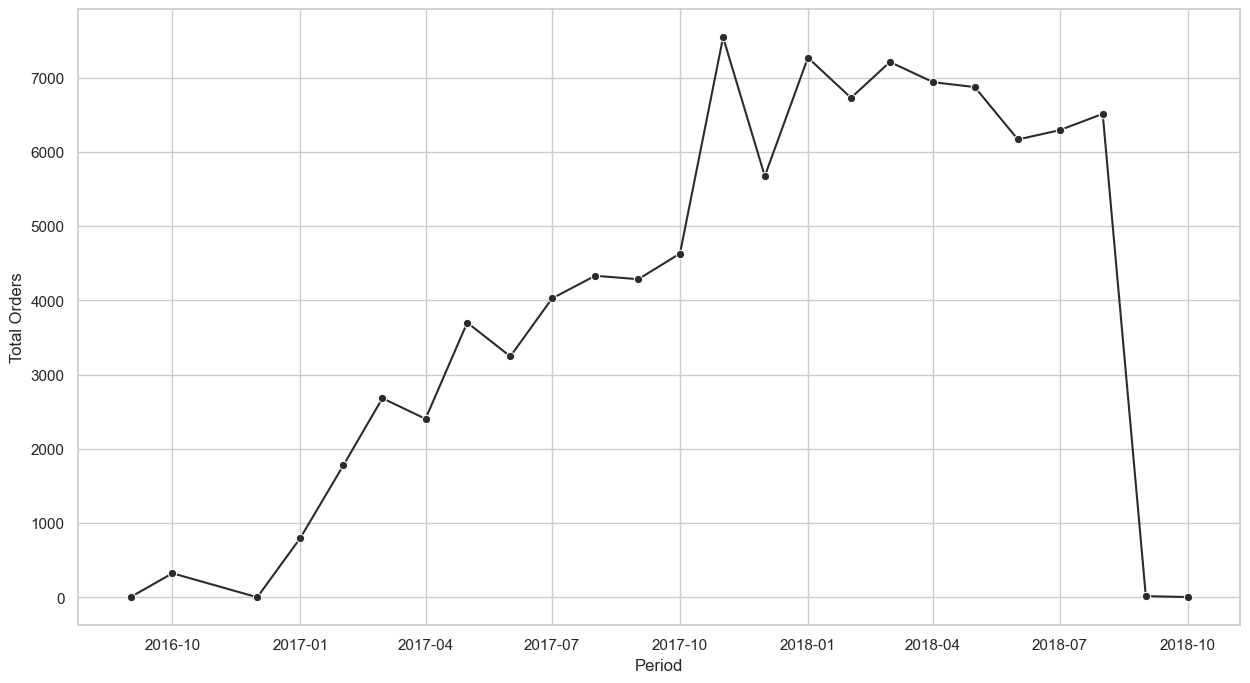

In [66]:
ax = sns.lineplot(data=df_2, x='dt_ref', y='tt_orders', marker='o')
ax.set_xlabel('Period')
ax.set_ylabel('Total Orders');

### 3. # of Orders per Day of the Week

In [57]:
df_3 = pd.read_sql("""
    SELECT DISTINCT TO_CHAR(purchase_ts, 'DAY') AS day_name,
        EXTRACT(ISODOW FROM purchase_ts) AS day_of_week,
        COUNT(DISTINCT order_id) as tt_orders
    FROM fact_orders
    GROUP BY 1,2
    ORDER BY 2 ASC
""", con=engine)

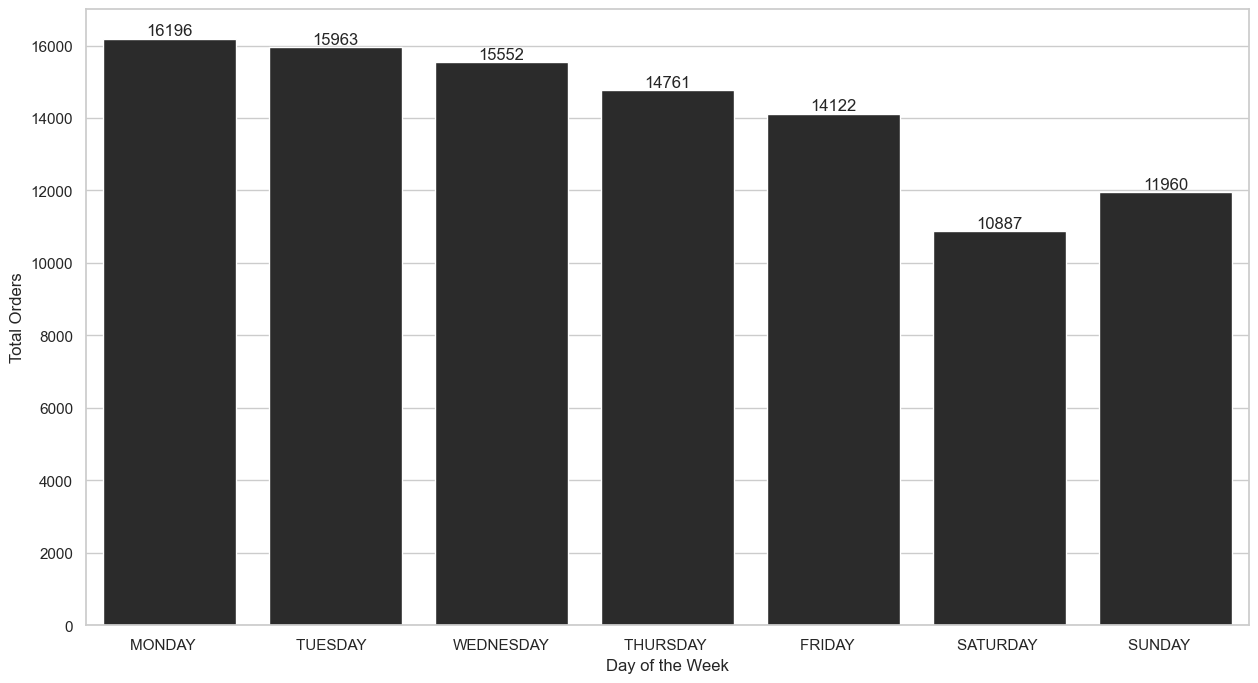

In [59]:
ax = sns.barplot(data=df_3, x='day_name', y='tt_orders')
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Total Orders')
ax.bar_label(ax.containers[0], fontsize=12);

### 4. # of Orders per Period of the Day

In [ ]:
df_4 = pd.read_sql("""
    WITH tb AS (
        SELECT DISTINCT EXTRACT(HOUR FROM purchase_ts) AS ref_hour,
            COUNT(DISTINCT order_id) as tt_orders
        FROM silver_orders
        GROUP BY 1
        ORDER BY 1 ASC
    ),
    final as (
    SELECT ref_hour, 
        CASE WHEN ref_hour BETWEEN 0 and 5 THEN 'Dawn'
            WHEN ref_hour BETWEEN 6 AND 12 THEN 'Morning'
            WHEN ref_hour BETWEEN 13 AND 18 THEN 'Afternoon'
            ELSE 'Night'
        END AS period_of_day,
        tt_orders
    FROM tb
    )
    SELECT period_of_day,
        SUM(tt_orders) as total_orders
    FROM final
    GROUP BY 1
""", con=engine)

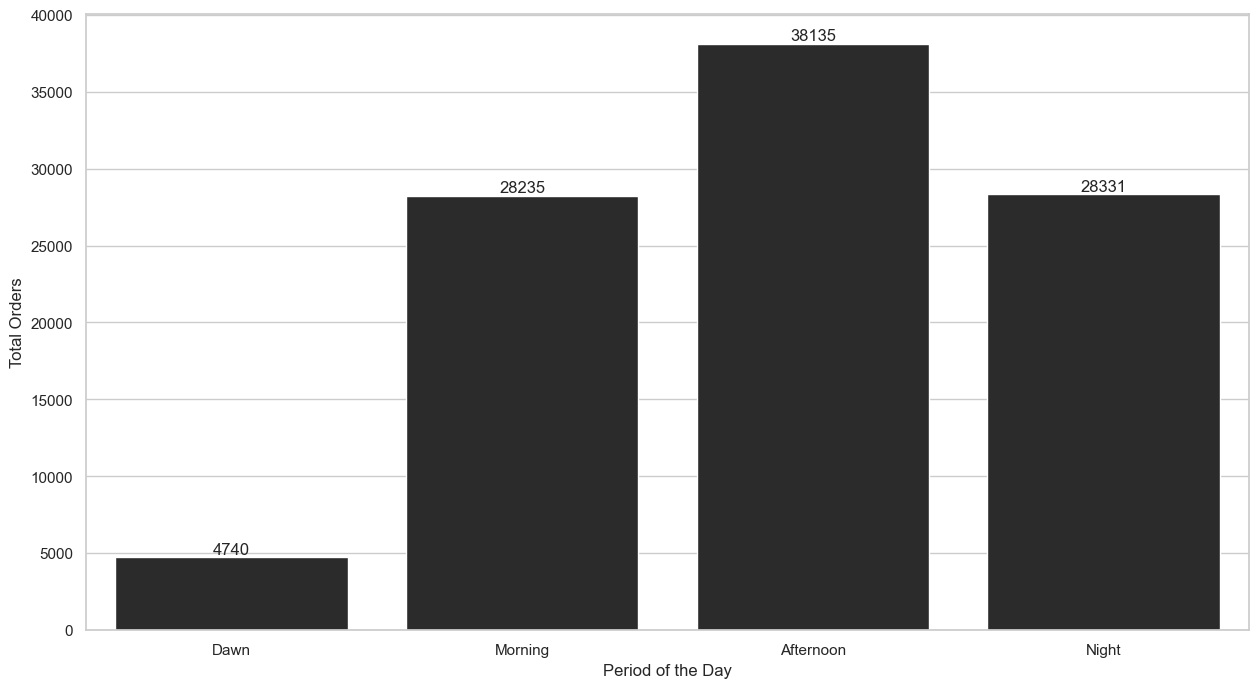

In [71]:
ax = sns.barplot(data=df_4, x='period_of_day', y='total_orders')
ax.set_xlabel('Period of the Day')
ax.set_ylabel('Total Orders')
ax.bar_label(ax.containers[0], fontsize=12);

### 5. # of Orders per Region

In [33]:
df_5 = pd.read_sql("""
    SELECT DISTINCT customer_state, 
      CASE WHEN customer_state IN ('SC', 'RS', 'PR') THEN 'Sul'
        WHEN customer_state IN ('SP', 'RJ', 'ES', 'MG') THEN 'Sudeste'
        WHEN customer_state IN ('MT', 'MS', 'GO', 'DF') THEN 'Centro-Oeste'
        WHEN customer_state IN ('MA', 'PI', 'BA', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE') THEN 'Nordeste'
        ELSE 'Norte'
        END AS customer_region, 
      COUNT(DISTINCT order_id) as tt_orders,
      COUNT(DISTINCT unique_customer_id) as tt_customers
    FROM fact_orders
    GROUP BY 1, 2
    ORDER BY 1 ASC
""", con=engine)

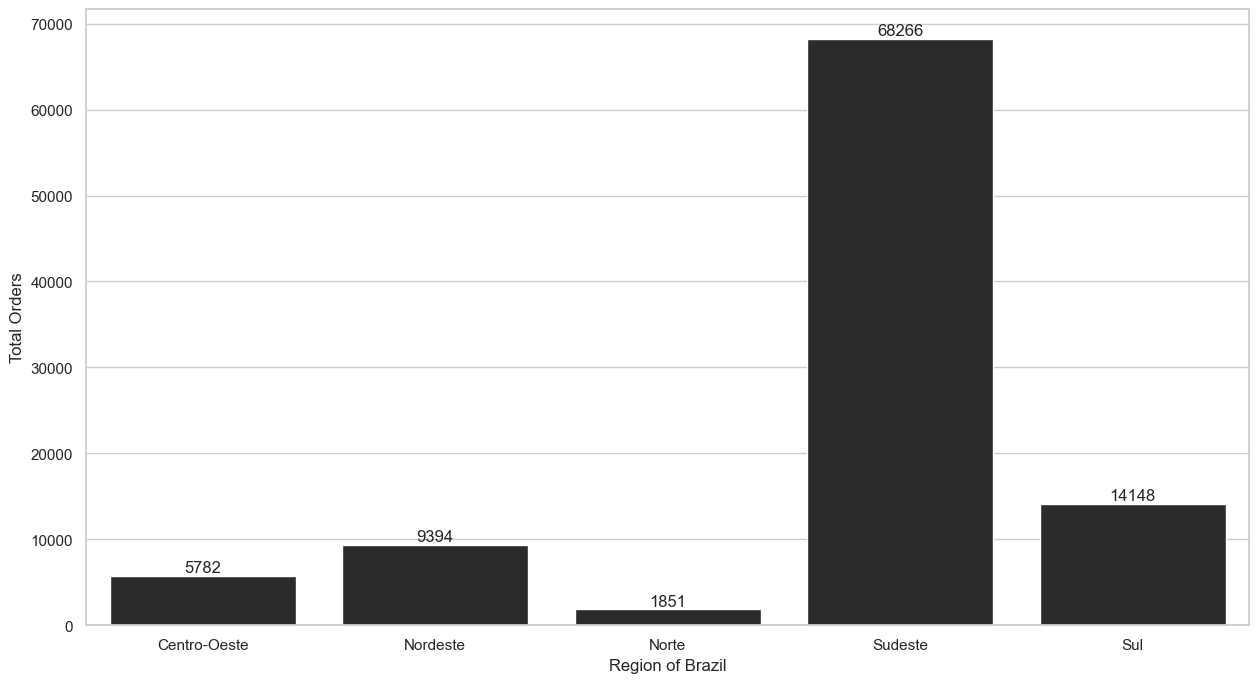

In [44]:
df_5_aux = df_5[['customer_region', 'tt_orders', 'tt_customers']].groupby('customer_region').sum().reset_index()

ax = sns.barplot(data=df_5_aux, x='customer_region', y='tt_orders')
ax.set_xlabel('Region of Brazil')
ax.set_ylabel('Total Orders')
ax.bar_label(ax.containers[0], fontsize=12);

### 6. Top 10 States

#### 6.1 Number of Orders

In [22]:
df_6_1 = df_5.sort_values(by='tt_orders', ascending=False)
df_6_chart_1 = df_6_1.iloc[0:10, :]

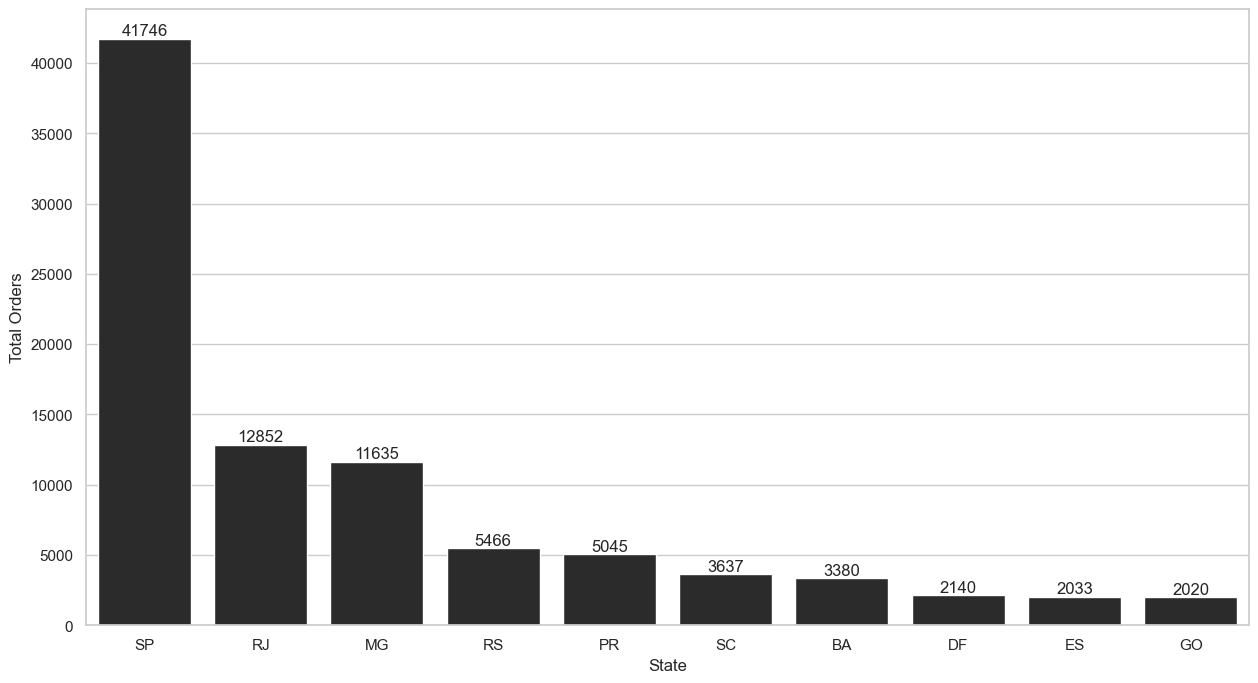

In [23]:
ax = sns.barplot(data=df_6_chart_1, x='customer_state', y='tt_orders')
ax.set_xlabel('State')
ax.set_ylabel('Total Orders')
ax.bar_label(ax.containers[0], fontsize=12);

#### 6.2 Number of Customers

In [31]:
df_6_2 = pd.read_sql("""
    SELECT DISTINCT customer_state,
      COUNT(DISTINCT unique_customer_id) as tt_customers
    FROM fact_orders
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 10
""", con=engine)

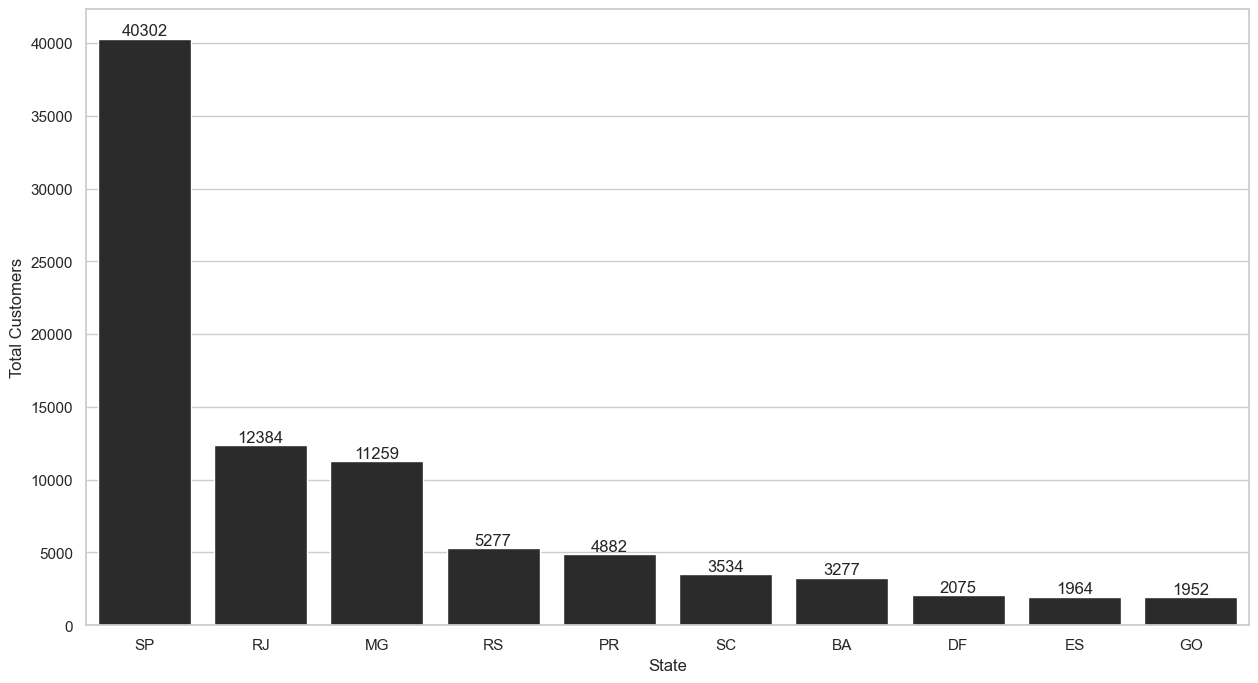

In [50]:
ax = sns.barplot(data=df_6_2, x='customer_state', y='tt_customers')
ax.set_xlabel('State')
ax.set_ylabel('Total Customers')
ax.bar_label(ax.containers[0], fontsize=12);

### 7. Top 10 Citys

#### 7.1 Number of Orders

In [ ]:
df_7_1 = pd.read_sql("""
    SELECT DISTINCT customer_city,
      COUNT(DISTINCT order_id) AS tt_orders
    FROM fact_orders
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 10
""", con=engine)

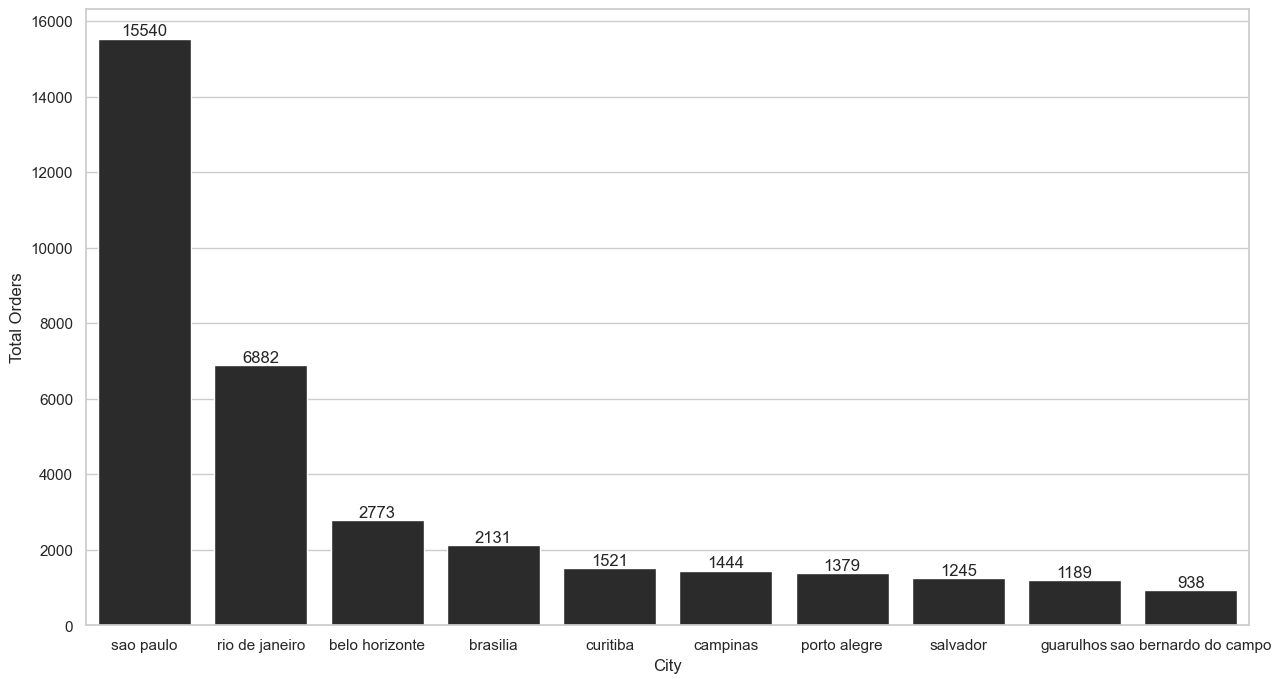

In [47]:
ax = sns.barplot(data=df_7_1, x='customer_city', y='tt_orders')
ax.set_xlabel('City')
ax.set_ylabel('Total Orders')
ax.bar_label(ax.containers[0], fontsize=12);

#### 7.2 Number of Customers

In [48]:
df_7_2 = pd.read_sql("""
    SELECT DISTINCT customer_city,
      COUNT(DISTINCT unique_customer_id) AS tt_customers
    FROM fact_orders
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 10
""", con=engine)

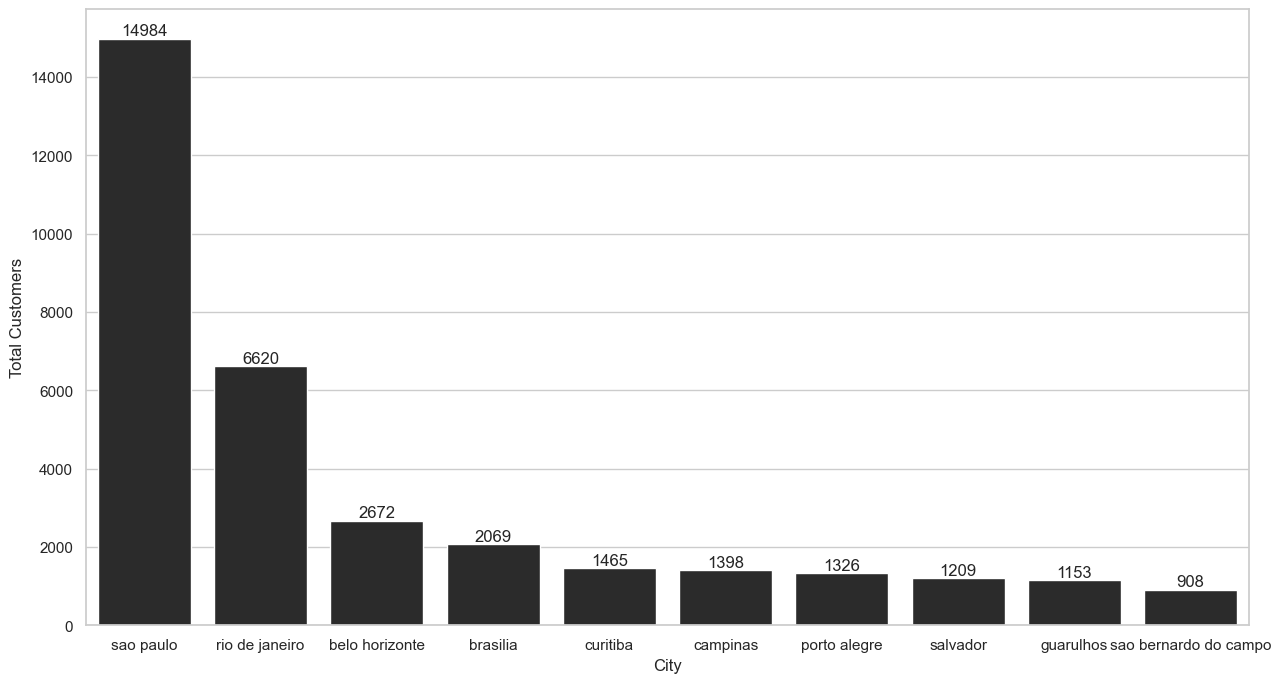

In [49]:
ax = sns.barplot(data=df_7_2, x='customer_city', y='tt_customers')
ax.set_xlabel('City')
ax.set_ylabel('Total Customers')
ax.bar_label(ax.containers[0], fontsize=12);

### 8. GMV Over Time

In [78]:
df_8 = pd.read_sql("""
    SELECT DISTINCT DATE(DATE_TRUNC('month', purchase_ts)) as dt_ref, 
        SUM(total_price) as tt_gmv
    FROM fact_orders
    GROUP BY 1
    ORDER BY 1 ASC
""", con=engine)

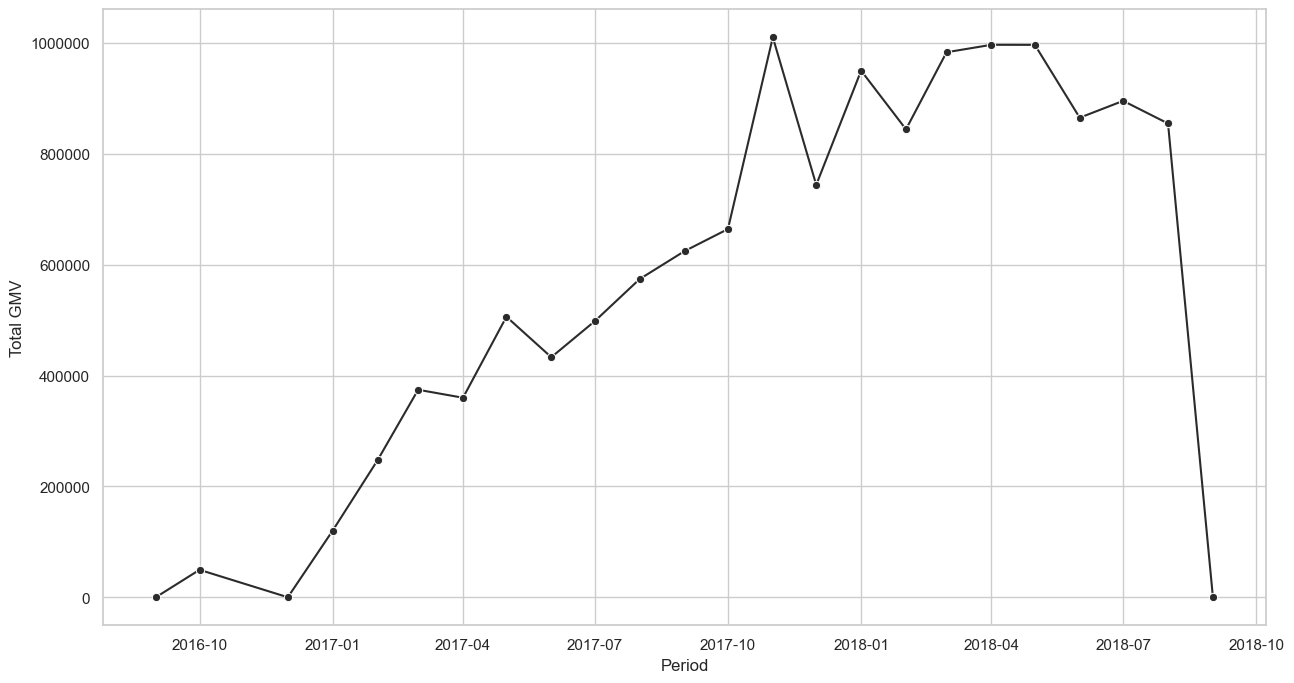

In [79]:
ax = sns.lineplot(data=df_8, x='dt_ref', y='tt_gmv', marker='o')
ax.set_xlabel('Period')
ax.set_ylabel('Total GMV')
plt.ticklabel_format(style='plain', axis='y')
plt.show();

### 9. Average Ticket Over Time

In [80]:
df_9 = pd.read_sql("""
    WITH tb AS (
      SELECT DISTINCT DATE(DATE_TRUNC('month', purchase_ts)) as dt_ref, 
          SUM(total_price) as tt_gmv, 
          COUNT(DISTINCT order_id) as tt_orders, 
          COUNT(DISTINCT unique_customer_id) AS tt_customers
      FROM fact_orders
      GROUP BY 1
      ORDER BY 1 ASC
    )
    SELECT DISTINCT dt_ref, 
      tt_gmv, 
      tt_orders, 
      tt_gmv / tt_orders AS avg_ticket_order, 
      tt_customers,
      tt_gmv / tt_customers AS avg_ticket_customer
    FROM tb
""", con=engine)

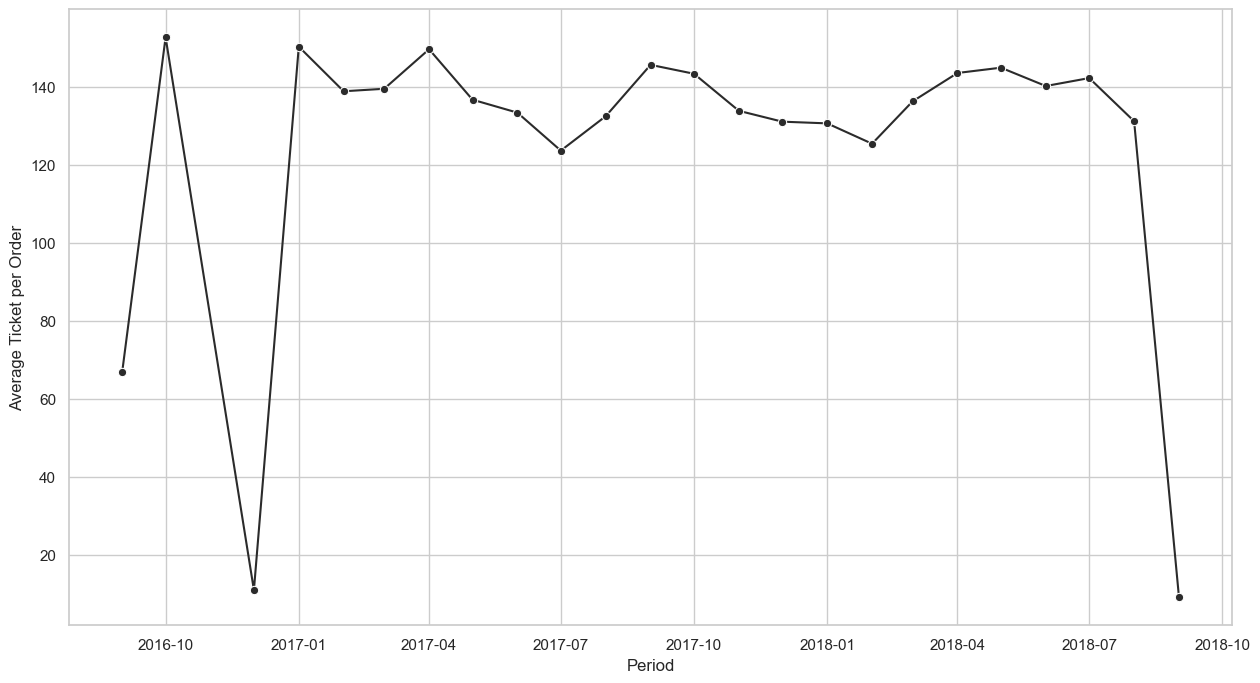

In [82]:
ax = sns.lineplot(data=df_9, x='dt_ref', y='avg_ticket_order', marker='o')
ax.set_xlabel('Period')
ax.set_ylabel('Average Ticket per Order')
plt.ticklabel_format(style='plain', axis='y')
plt.show();

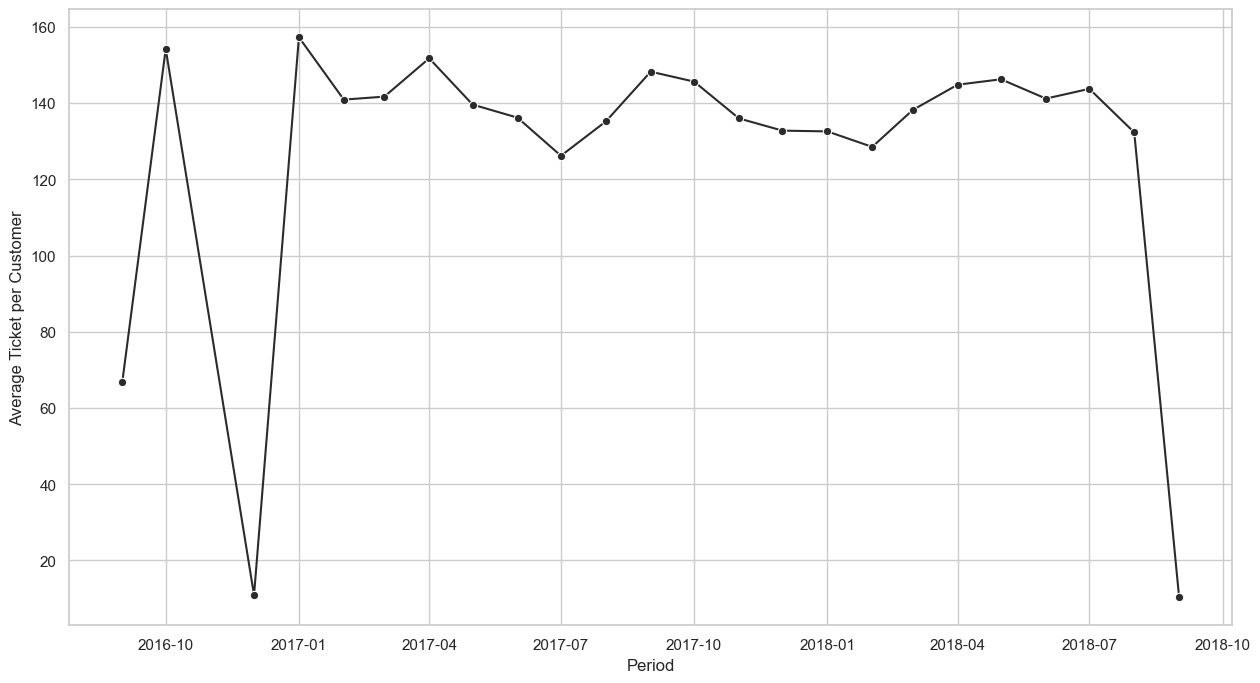

In [83]:
ax = sns.lineplot(data=df_9, x='dt_ref', y='avg_ticket_customer', marker='o')
ax.set_xlabel('Period')
ax.set_ylabel('Average Ticket per Customer')
plt.ticklabel_format(style='plain', axis='y')
plt.show();

### 10. # of Payments by Payment Type

In [93]:
df_10 = pd.read_sql("""
    SELECT DISTINCT method, 
      COUNT(*) as tt_payments, 
      COUNT(DISTINCT order_id) as tt_orders
    FROM silver_payments
    GROUP BY 1
    ORDER BY 2 DESC
""", con=engine)

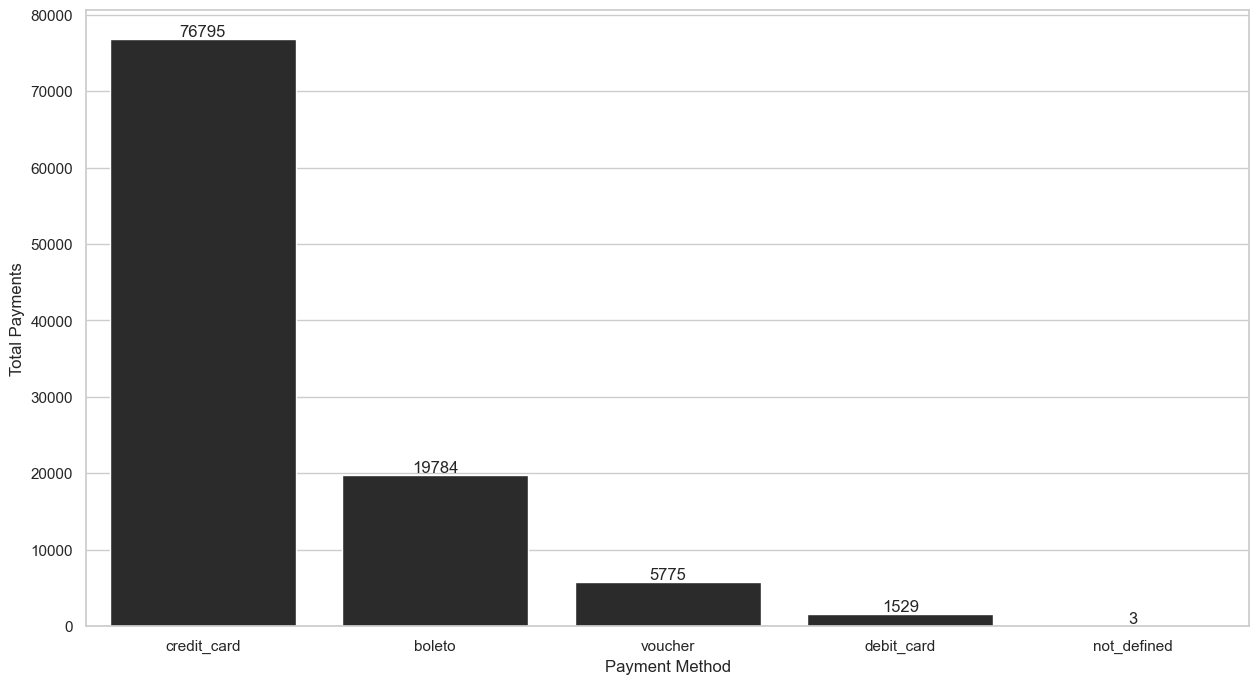

In [94]:
ax = sns.barplot(data=df_10, x='method', y='tt_payments')
ax.set_xlabel('Payment Method')
ax.set_ylabel('Total Payments')
ax.bar_label(ax.containers[0], fontsize=12);

### 11. # of Payments by Payment Type Over Time

In [95]:
df_11 = pd.read_sql("""
  WITH pay AS (
    SELECT DISTINCT order_id, 
      method
    FROM silver_payments
  ),
  orders AS (
    SELECT DISTINCT order_id, 
      purchase_ts
    FROM fact_orders
  ),
  joined AS (
    SELECT p.order_id, 
      p.method, 
      o.purchase_ts
    FROM pay AS p
    LEFT JOIN orders AS o
      ON p.order_id = o.order_id
  )  
  SELECT DISTINCT DATE(DATE_TRUNC('month', purchase_ts)) as dt_ref,
    method, 
    COUNT(*) as tt_payments, 
    COUNT(DISTINCT order_id) as tt_orders   
  FROM joined
  GROUP BY 1, 2
  ORDER BY 1 ASC
""", con=engine)

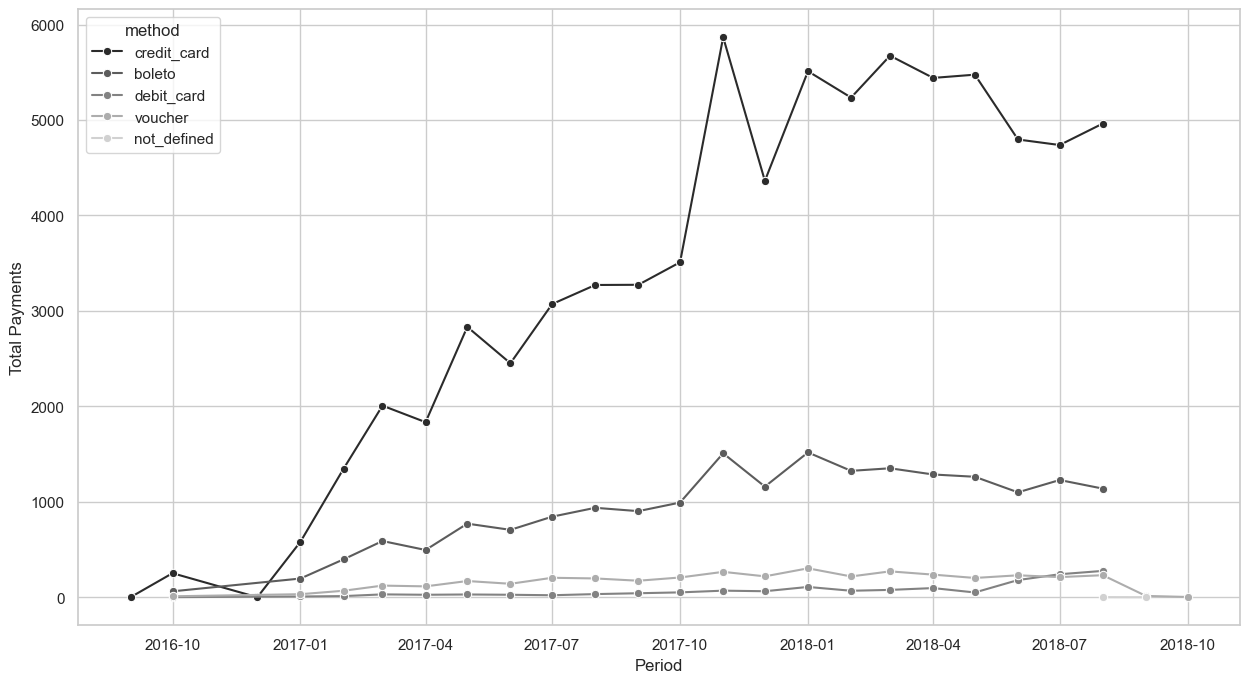

In [97]:
ax = sns.lineplot(data=df_11, x='dt_ref', y='tt_payments', hue='method', marker='o')
ax.set_xlabel('Period')
ax.set_ylabel('Total Payments')
plt.ticklabel_format(style='plain', axis='y')
plt.show();

### 12. # of Active Sellers Over Time

In [100]:
df_12 = pd.read_sql("""
  SELECT DISTINCT DATE(DATE_TRUNC('month', purchase_ts)) as dt_ref,
    COUNT(DISTINCT seller_id) as tt_sellers   
  FROM fact_order_items
  GROUP BY 1
  ORDER BY 1 ASC
""", con=engine)

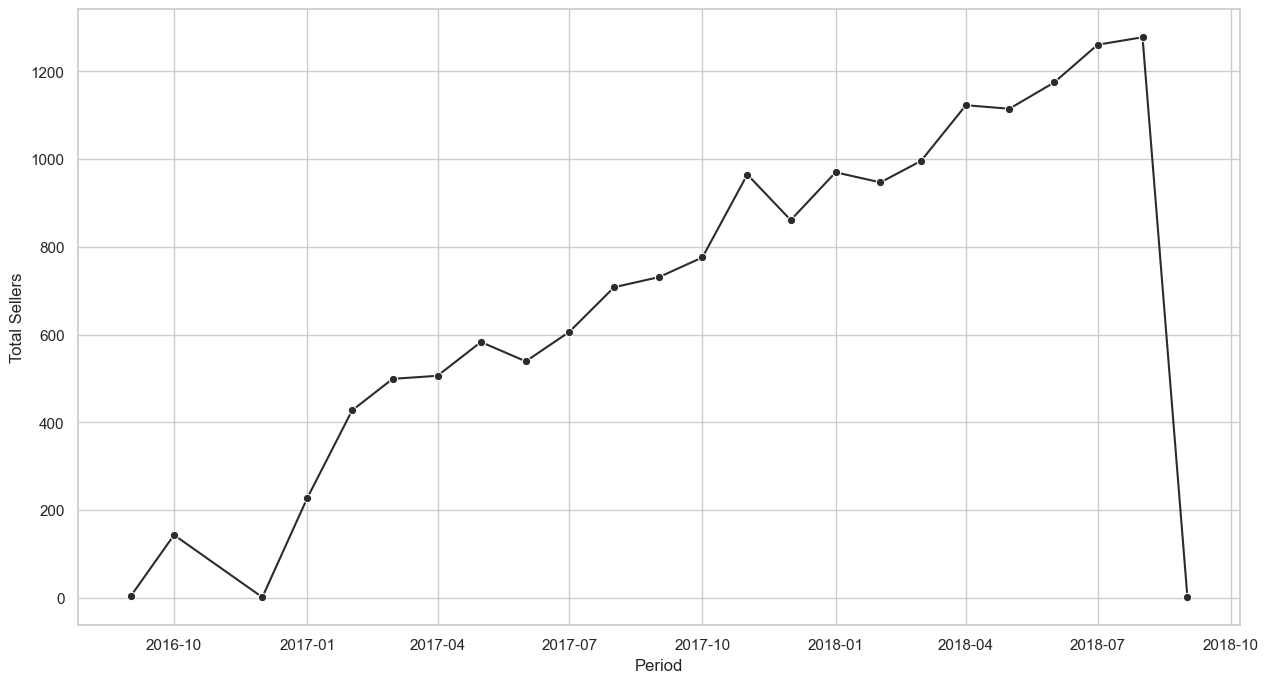

In [102]:
ax = sns.lineplot(data=df_12, x='dt_ref', y='tt_sellers', marker='o')
ax.set_xlabel('Period')
ax.set_ylabel('Total Sellers')
plt.ticklabel_format(style='plain', axis='y')
plt.show();

### 13. Top 10 Sellers

In [131]:
df_13 = pd.read_sql("""
  WITH topten AS (
    SELECT DISTINCT seller_id,
      COUNT(DISTINCT order_id) as tt_orders   
    FROM fact_order_items
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 10
  ),
  category AS (
    SELECT DISTINCT seller_id,
      category_name,
      COUNT(DISTINCT order_id) as tt_orders,
      ROW_NUMBER() OVER(PARTITION BY seller_id ORDER BY COUNT(DISTINCT order_id) DESC) AS rn
    FROM fact_order_items
    GROUP BY 1,2
  )
  SELECT DISTINCT t.seller_id, 
    t.tt_orders,
    c.category_name
  FROM topten AS t
  JOIN category AS c
    on t.seller_id = c.seller_id
  WHERE c.rn = 1
  ORDER BY 2 DESC
""", con=engine)

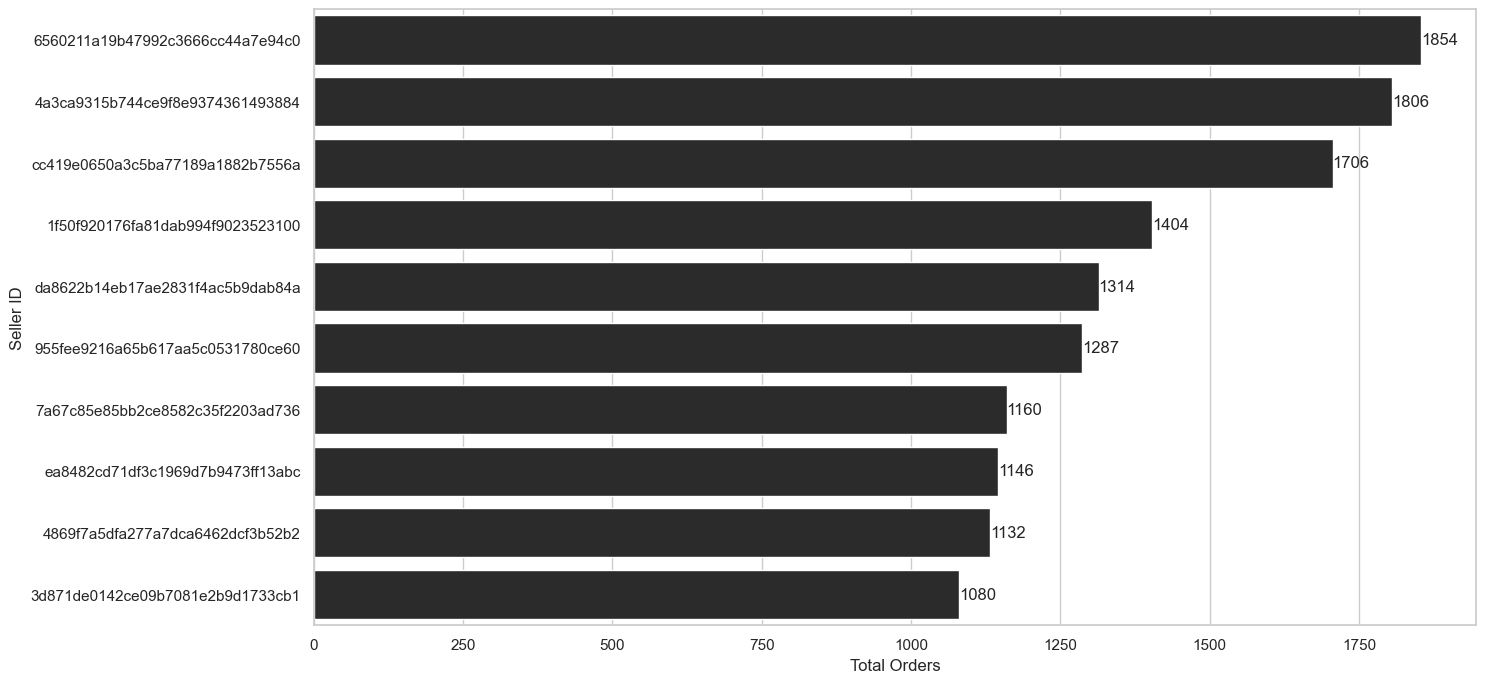

In [139]:
ax = sns.barplot(data=df_13, x='tt_orders', y='seller_id', orient='h')
ax.set_xlabel('Total Orders')
ax.set_ylabel('Seller ID')
ax.bar_label(ax.containers[0], fontsize=12);

### 14. Top 10 Categories